In [ ]:
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorfl

In [ ]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"
data = pd.read_csv(f'{DDSM_dir}/training/metadata.csv')

IMAGES = np.load(f'{DDSM_dir}/training/images.npy', allow_pickle=True)
MASKS = np.load(f'{DDSM_dir}/training/masks.npy', allow_pickle=True)

print(len(data))
print(IMAGES.shape)
print(MASKS.shape)

3568
(3568, 256, 256, 1)
(3568, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split

IMAGES_sub = np.split(IMAGES, 223)[0] ## remvoe this
MASKS_sub = np.split(MASKS, 223)[0] ## remove this


# Split dataset into train and test sets (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(IMAGES_sub, MASKS_sub, test_size=0.2, random_state=42)

# Split training set into train and validation sets (80/20 split)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def unet(input_size = (256,256,1), start_neurons=64):
    input_layer = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, 3, activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, 3, activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, 3, strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, 3, activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, 3, strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, 3, activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, 3, strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, 3, activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, 3, strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, 3, activation="relu", padding="same")(uconv1)

    covout = Conv2D(2,1,activation="relu", padding="same")(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(covout)

    model = Model(inputs = [input_layer], outputs = [output_layer])
    
    return model

In [ ]:
def unet2(input_size = (256,256,1)):

    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

**Loss**

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):

	intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
	return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
	return 1-dice_coef(y_true, y_pred)


In [ ]:
from segmentation_models.losses import bce_jaccard_loss 

Segmentation Models: using `keras` framework.


**Metrics**

In [ ]:
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)

def iou(y_true, y_pred, smooth=1):
	intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
	union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
	iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
	return iou

def pixel_accuracy(y_true, y_pred):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.round(tf.reshape(y_pred, [-1]))  # round to get 0 or 1 prediction
    
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32))
    total_pixels = tf.cast(tf.size(y_true_f), tf.float32)
    
    return correct_pixels / total_pixels


metrics = [iou,'binary_accuracy',pixel_accuracy]

**callbacks**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callback= [ModelCheckpoint('/content/drive/MyDrive/models/m2.h5',verbose =1, save_best_only=True),
    EarlyStopping(patience = 20, verbose =1, restore_best_weights=True ,monitor = "val_loss")]

**optimizer**

In [ ]:
from keras.optimizers import Adam

learning_rate = 0.001 ##

# beta parameters
beta_1 = 0.9
beta_2 = 0.999

optimizer = Adam(lr=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

**model**

In [ ]:
model = unet2()

In [ ]:
model.compile('adam', loss=bce_jaccard_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_190 (Conv2D)            (None, 256, 256, 64  640         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_191 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_190[0][0]']             
                                )                                                           

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 55.8 MB/s eta 0:00:00


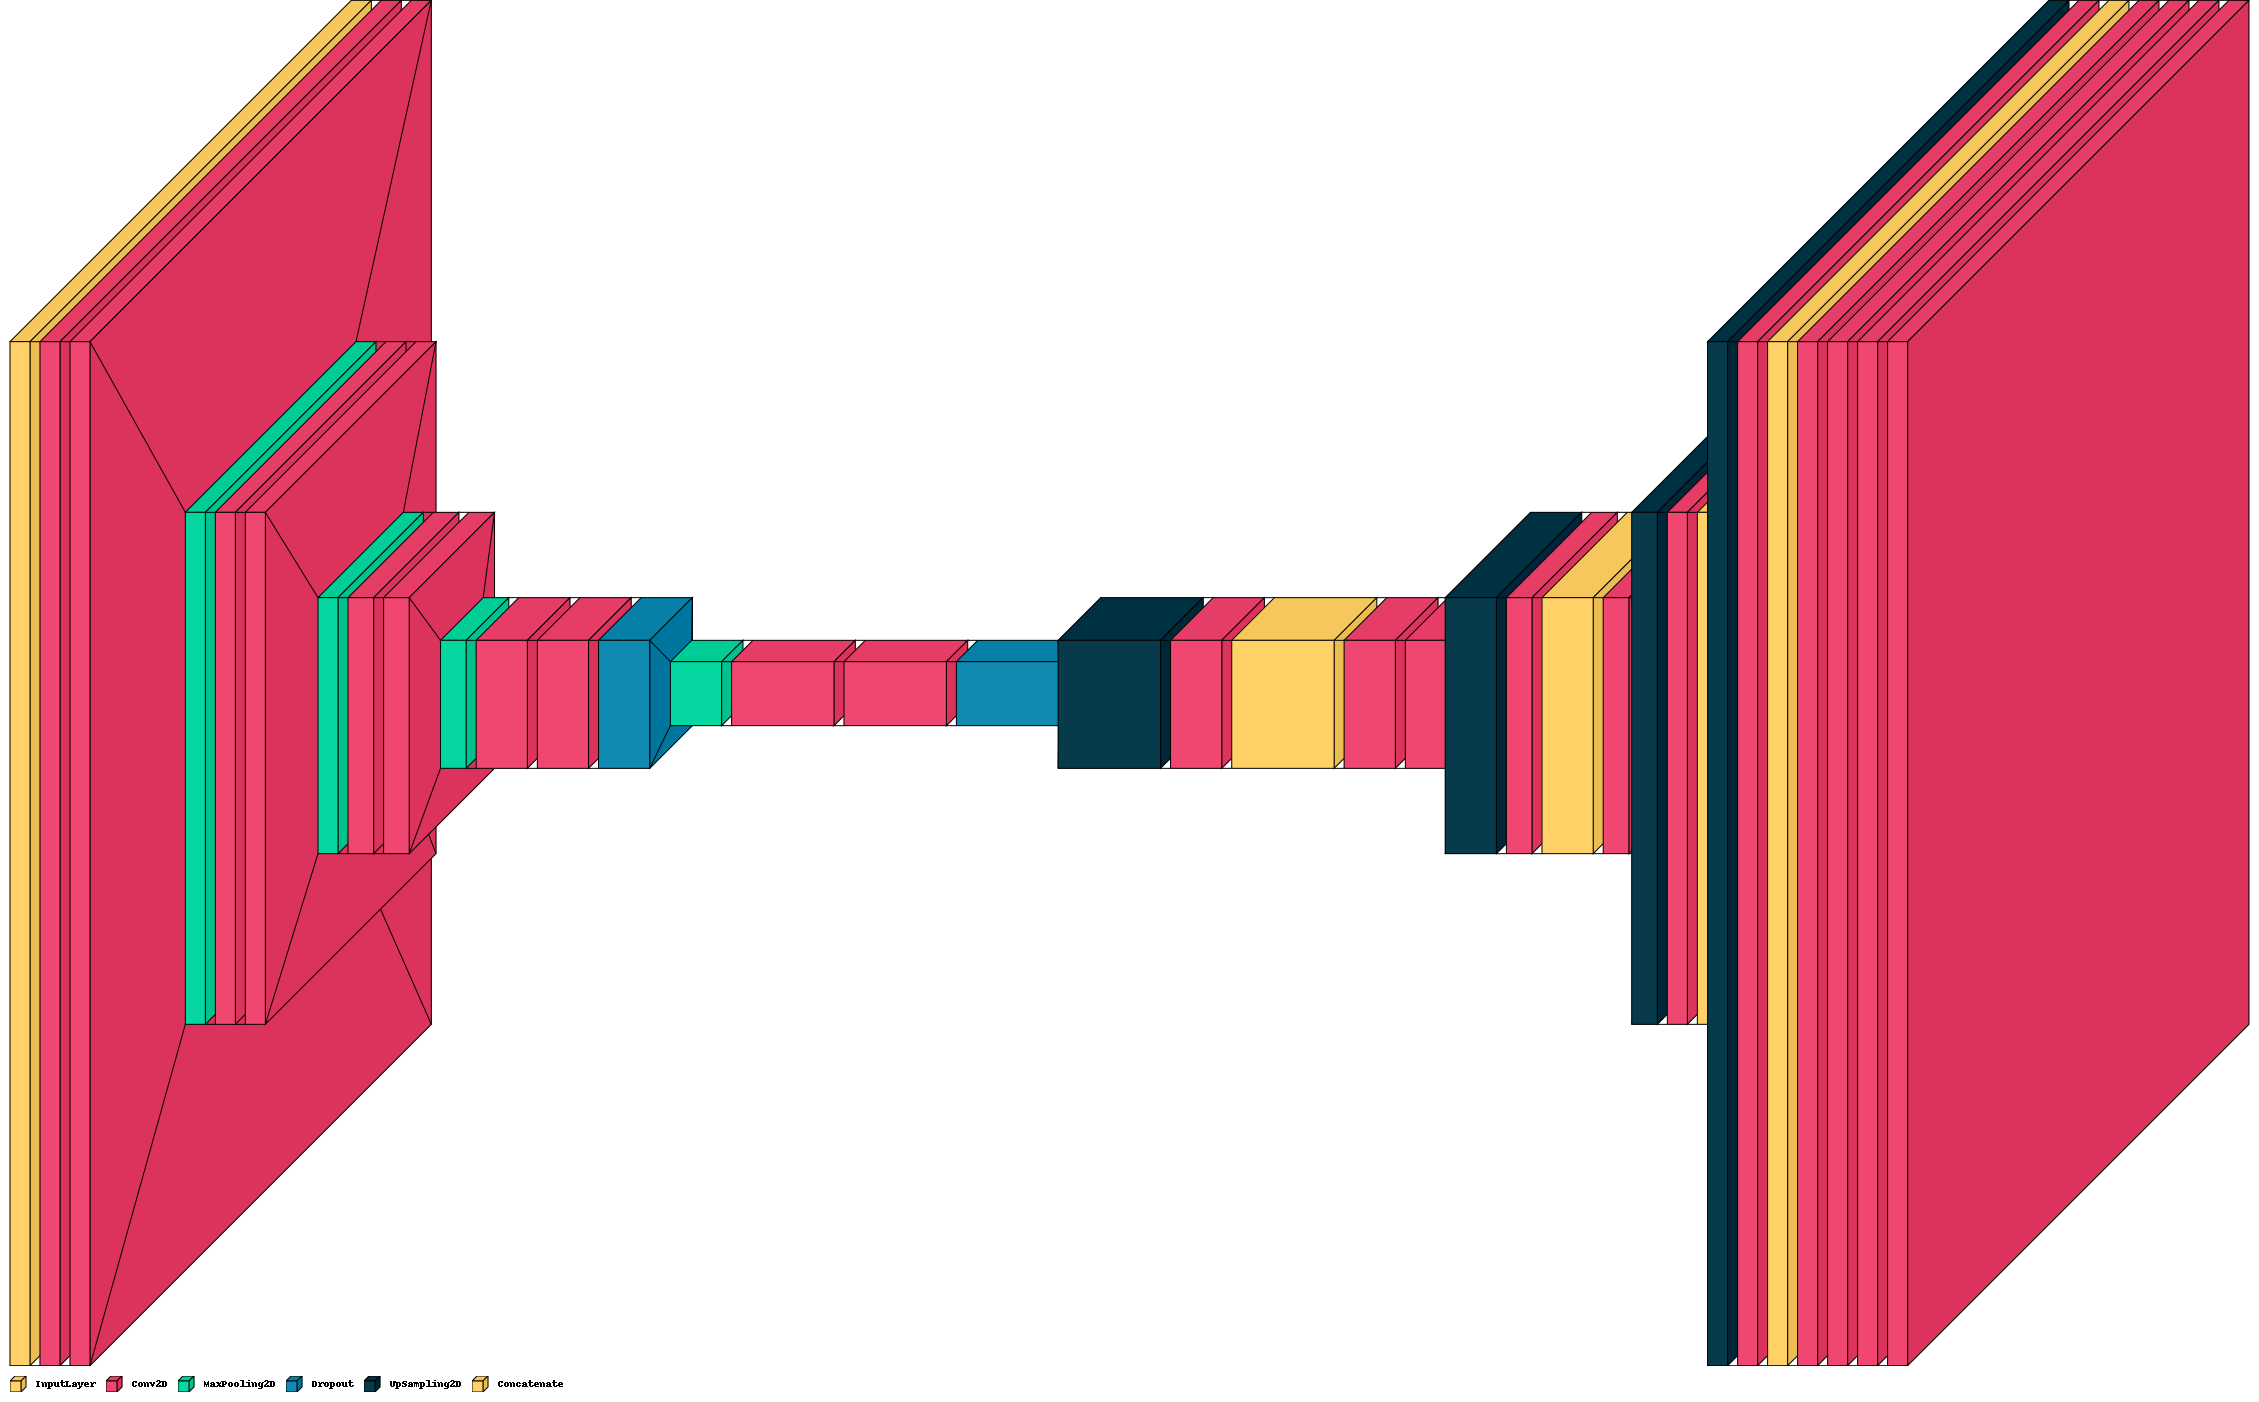

In [ ]:
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)

**Fitting**

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

batch_size = 1 ##
train_steps = x_train.shape[0] // batch_size
test_steps = x_val.shape[0] // batch_size

model.fit(x=x_train, 
          y=y_train, 
          epochs=100,
          steps_per_epoch = train_steps, 
          validation_steps= test_steps ,
          callbacks = callback,
          batch_size = batch_size, 
          validation_data=(x_val, y_val))

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 10.5660 - iou: 0.0036 - binary_accuracy: 0.8879 - pixel_accuracy: 0.8879
Epoch 1: val_loss did not improve from 0.00535
9/9 [==============================] - 8s 794ms/step - loss: 10.5660 - iou: 0.0036 - binary_accuracy: 0.8879 - pixel_accuracy: 0.8879 - val_loss: 1.2008 - val_iou: 3.1629e-04 - val_binary_accuracy: 0.9900 - val_pixel_accuracy: 0.9900
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 1.0772 - iou: 0.0026 - binary_accuracy: 0.9954 - pixel_accuracy: 0.9954
Epoch 2: val_loss did not improve from 0.00535
9/9 [==============================] - 4s 547ms/step - loss: 1.0772 - iou: 0.0026 - binary_accuracy: 0.9954 - pixel_accuracy: 0.9954 - val_loss: 1.0881 - val_iou: 0.0105 - val_binary_accuracy: 0.9900 - val_pixel_accuracy: 0.9900
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 1.0508 - iou: 0.0044 - binary_accuracy: 0.9954 - pixel_accuracy: 0.9954
Epoch 3: val_loss did not

**ploting samples of the predectied**

In [ ]:
from matplotlib import pyplot as plt

def plot_image(img):
  plt.imshow(img.reshape(256,256), interpolation='nearest',cmap='gray')
  plt.show()
  return plt

In [ ]:
predicted = model.predict(x_test)

1/1 [==============================] - 0s 210ms/step


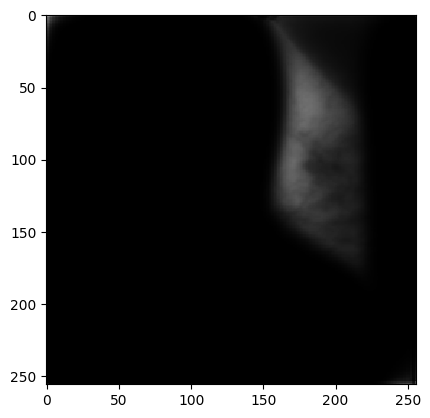

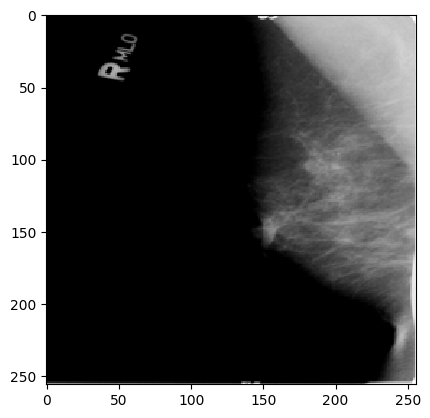

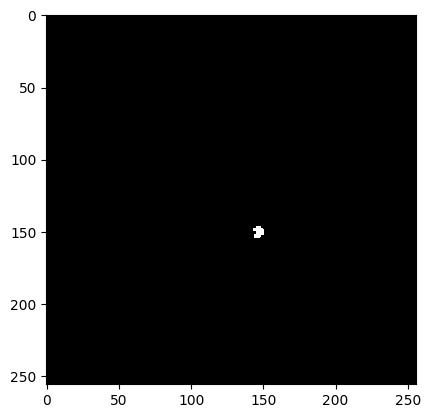

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_image(predicted[3])
plot_image(x_test[3])
plot_image(y_test[3])